In [1]:
# useful modules
import matplotlib.pyplot as plt
import os
import numpy as np

# allows us to access the modules directory in the repository
import sys
sys.path.append('../functions/')

# just my personal preferences for plotting in Jupyter
plt.rcParams['font.size'] = '16'
plt.rcParams['figure.figsize'] = [7, 5]
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
  display: table-cell;
  text-align: center;
  vertical-align: middle;
}
</style>
""")

# Quickstart Tutorial: Coordination in a threshold game

The purpose of this tutorial is to allow the reader to quickly get started using our method. For this purpose, we will use coordinated cooperation in a threshold public goods game as our example. To implementing your own cooperation scenario, you will need to replace `ThresholdUDCL` class below, particularly the `payoff()` method. To find this example as stand-alone scripts (i.e., not embedded in a Jupyter Notebook), please refer to the repository directory: `/scripts/thresholdUDCL/`.

## 1. Specify the scenario and payoff function

Let us begin by defining some game parameter values.

We will consider the evolutionary dynamics of the 4 strategies described in the main text: Unconditional Cooperators (U), Unconditional Defectors (D), Coordinating Cooperators (C), and Liars (L). 

The cognitive cost that Coordinating Cooperators and Liars pay for understanding how the game works and coordinating the lottery is $-0.1$.

Groups will play the threshold public goods game, where a public good is provided when the number of contributors in the group meets a minimum threshold, $\tau \geq 5$. 

The cost of contributing to the public good is $-1$. 

The benefit produced by the public good when the threshold is met is $3$.

In [3]:
game_pars = {
        'strat_names': ['D', 'C', 'L', 'U'],
        'cognitive_cost': -0.1, # a small cost to understanding coordination
        'tau': 5,               # lottery quorum and midpoint of benefits function minus 0.5
        'contrib_cost': -1,     # cost of contributing to public good
        'benefit_thresh_met': 3 # benefit when threshold is met
        }

We want to model genetically homophilic group formation, so we will define evolutionary parameter values, which are those used to calculate the probability of different group strategy distributions using the homophilic group-formation model.

We choose 8 individuals per group.

The number of strategies is 4.

We will use the 'members recruit' group-formation model, where the initial member is chosen at random, and current group members have an equal chance to recruit the next member. 

Members recruit nonkin with probability $q$ kin with probability $1-q$ (i.e., homophily $h = 1-q$). We will choose $q=0.8$.

To use the members-recruit model, we need to specify where the combinatorial terms need for the homophily calculation are stored, which is in the repository in the directory `members_recruit_comb_term/`

We must also specify where the coefficients $C(\Phi)$ and the powers in $A(\Phi, \boldsymbol{p})$ are stored, which is in the repository in the directory `results/partn2prob/`

In [4]:
evol_pars = {
        'n': 8,                                     # group size
        'n_s': 4,                                   # number of strategies
        'group_formation_model': 'members recruit', # group formation model
        'q': 0.5,                                   # parameter for leader-driven model
        'sumprodm_dir': os.path.abspath('../members_recruit_comb_term/'),
        'partn2prob_dir': os.path.abspath('../results/partn2prob/'),
        }

To specify the model, we will make use of the abstract base class `ModelBase` in `functions/model_base.py`.

In [5]:
from model_base import ModelBase

# ModelBase.payoff? # uncomment this line to see the help documentation quoted below

 `ModelBase` has an abstract method called `payoff()`, which accepts a group's strategy distribution and returns the payoff to the focal strategy. The help documentation reads:

```
Signature: ModelBase.payoff(self, strats, strat_counts)
Docstring:
Write a function that accepts strategy distribution and returns payoff.  Ensure the game_pars 
dictionary has all the parameters it needs.

Inputs:
---

strats, list of str:
    A list of the strategy names in the same order as strat_counts.  Index 0 in strats is 
    treated as the focal strategy.

strat_counts:
    How many individuals in the group are pursuing which strategies.  For example, if 
    strats = ['C', 'D', 'P'] and strat_counts = [2, 1, 3], then the group has 2 
    cooperators, 1 defector, and 3 punishers.

Outputs:
---

payoff, float
    Payoff to and individual playing the focal strategy (strats[0], cooperators in example 
    above) given the distribution of strategies in strat_counts.
File:      ~/work/hisashi/code/togit_homophilic_mstrat/functions/model_base.py
Type:      function
```

We will create a class `ThresholdUDCL` that inherits the `ModelBase` class and implements the `payoff()` method corresponding to a threshold game.

In [6]:
from scipy.special import binom

class ThresholdUDCL(ModelBase):

    def __init__(self, *args, **kwargs):

        # inherit everything
        super(self.__class__, self).__init__(*args, **kwargs)

        # we now have names for the strategies
        self.strat_names = self.game_pars['strat_names']


    def __str__(self):

        s = super().__str__()
        s += 'A threshold game with a lottery mechanic adding Coordinated Cooperators and Liars.\n'

        return s


    def payoff(self, strats, strat_counts):

        # parameters to set up game
        # ---

        n = self.n # group size
        tau = self.game_pars['tau'] # both the quorum and the threshold
        cognitive_cost = self.game_pars['cognitive_cost']
        contrib_cost = self.game_pars['contrib_cost']
        benefit_thresh_met = self.game_pars['benefit_thresh_met']

        
        # we calculate the payoff for the focal strategy, which is always the first strategy in strats
        # ---
        
        focal_strat = strats[0]


        # check we got sensible inputs
        # ---

        assert(sum(strat_counts) == n)
        assert(strat_counts[0] > 0)


        # calculate the payoff to the focal
        # ---

        # count the number of each strategy in the group

        countDict = dict(zip(strats, strat_counts))
        countU = 0 if 'U' not in countDict else countDict['U'] # Unconditional Cooperators
        countD = 0 if 'D' not in countDict else countDict['D'] # Unconditional Defectors
        countC = 0 if 'C' not in countDict else countDict['C'] # Coordinating Cooperators
        countL = 0 if 'L' not in countDict else countDict['L'] # Liars


        # payoff calculation depends on whether or not the lottery quorum is met
        # ---

        if countC + countL < tau: # if the lottery quorum is not met

            k = countU                                      # only U will contribute
            benefit = benefit_thresh_met if k >= tau else 0 # benefit from PGG

            # payoff returned depends on the focal strategy
            
            if focal_strat == 'U':

                payoff_total = benefit + contrib_cost

            elif focal_strat == 'D':

                payoff_total = benefit

            else: # focal_strat == C or L

                payoff_total = benefit + cognitive_cost

        else: # if the lottery quorum is met

            # probability that j Coordinating Cooperators (in contrast to Liars)
            # will be designated as contributors by the lottery
            
            denom = binom(countC + countL, tau)
            PjV = [binom(countC, j)*binom(countL, tau-j)/denom for j in range(0, tau+1)]

            # the benefit returned for each j
            benefitjV = [benefit_thresh_met if j+countU >= tau else 0 for j in range(0, tau+1)]

            # payoff returned depends on the focal strategy
            
            if focal_strat == 'U':

                payoff_total = sum(Pj*benefitj for Pj, benefitj in zip(PjV, benefitjV)) + contrib_cost

            elif focal_strat == 'D':

                payoff_total = sum(Pj*benefitj for Pj, benefitj in zip(PjV, benefitjV))

            elif focal_strat == 'C':

                payoff_total = sum(PjV[j]*(benefitjV[j] + contrib_cost*j/countC) for j in range(0, tau+1)) + cognitive_cost

            else: # focal_strat == 'L':

                payoff_total = sum(Pj*benefitj for Pj, benefitj in zip(PjV, benefitjV)) + cognitive_cost


        return payoff_total


## 2. Initialise the model

We can now initialise the model by instantiating the `ThresholdUDCL` class, which incorporates the `payoff()` method above and calculates the necessary outputs from the group-formation model (e.g., partition-structure probabilities $F$).

In [7]:
thresholdUDCL = ThresholdUDCL(evol_pars, game_pars)

### 2.1 Features of the model object

The initialisation incorporates our `payoff()` method into the `thresholdUDCL` model object. For example, we could now plot the payoffs to Coordinating Cooperators and Defectors using `thresholdUDCL`.

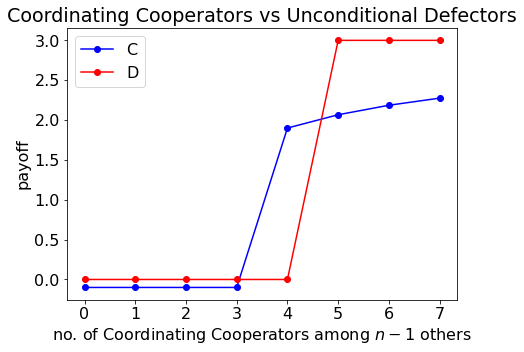

In [8]:
strats = ['C', 'D']
n = evol_pars['n']
strat_countsV = [ [i, n-i] for i in range(1, n+1) ]

# strategy C payoffs 
aV = [thresholdUDCL.payoff(strats, strat_counts) for strat_counts in strat_countsV]

# strategy D payoffs 
r_strats = list(reversed(strats))
bV = [thresholdUDCL.payoff(r_strats, strat_counts) for strat_counts in reversed(strat_countsV)]

plt.plot(range(n), aV, '-o', color='blue', label='C')
plt.plot(range(n), bV, '-o', color='red', label='D')
plt.title('Coordinating Cooperators vs Unconditional Defectors')
plt.xlabel(r'no. of Coordinating Cooperators among $n-1$ others', fontsize='medium')
plt.ylabel(r'payoff', fontsize='medium')
plt.legend(loc='best')
plt.show()

The initialisation also gives us necessary statistics and terms needed to account for homophilic group formation.

A "compressed" version of the $C(\Phi)$ coefficients and $A(\Phi, \boldsymbol{p})$ powers from `../results/partn2prob/` are now stored in matrices in `thresholdUDCL`

In [9]:
# print the first 3 rows and columns

for row in range(3):
    print(f'{thresholdUDCL.CM[row][:3]}...')

[(1680,), (180, 60, 60), (30,)]...
[(8,), (6,), (5,)]...
[(280,), (60, 30), (20, 5)]...


In [10]:
for row in range(3):
    print(f'{thresholdUDCL.WM[row][:3]}...')

[((1, 2, 2, 3),), ((1, 2, 2, 2), (1, 2, 1, 3), (1, 1, 2, 3)), ((1, 2, 2, 1),)]...
[((1, 0, 0, 7),), ((1, 0, 0, 6),), ((1, 0, 0, 5),)]...
[((1, 0, 3, 4),), ((1, 0, 3, 3), (1, 0, 2, 4)), ((1, 0, 3, 2), (1, 0, 1, 4))]...


The probabilities of different family partition structures $F$ were calculated during the initialisation and are stored in `thresholdUDCL`. 

In [11]:
# print a table of family partition structures and their probabilities

def print_F_table():
    
    print('family partition structure | probability of partn structure, F')
    print('-------------------------- | ---------------------------------')

    for partn, F in zip(thresholdUDCL.partnV, thresholdUDCL.F):

        partn_str = str(partn)
        partn_str = partn_str + ' '*(26-len(partn_str))
        print(partn_str + f' | {F}')
        
print_F_table()

family partition structure | probability of partn structure, F
-------------------------- | ---------------------------------
[1, 1, 1, 1, 1, 1, 1, 1]   | 0.0078125
[1, 1, 1, 1, 1, 1, 2]      | 0.0546875
[1, 1, 1, 1, 1, 3]         | 0.06886160714285715
[1, 1, 1, 1, 2, 2]         | 0.09520089285714285
[1, 1, 1, 1, 4]            | 0.08444940476190477
[1, 1, 1, 2, 3]            | 0.1472594246031746
[1, 1, 1, 5]               | 0.0859747023809524
[1, 1, 2, 2, 2]            | 0.04172867063492063
[1, 1, 2, 4]               | 0.10136718750000001
[1, 1, 3, 3]               | 0.03860987103174603
[1, 1, 6]                  | 0.06529017857142856
[1, 2, 2, 3]               | 0.04530319940476191
[1, 2, 5]                  | 0.04899553571428572
[1, 3, 4]                  | 0.032421875
[1, 7]                     | 0.032366071428571425
[2, 2, 2, 2]               | 0.0021825396825396826
[2, 2, 4]                  | 0.009821428571428573
[2, 3, 3]                  | 0.007533482142857143
[2, 6]           

These may be updated without reinitialising the whole model using the `update_F()` method, which is useful for exploring how the dynamics change with changing homophily level.

In [12]:
thresholdUDCL.evol_pars['q'] = 0.8
thresholdUDCL.update_F()

print_F_table()

family partition structure | probability of partn structure, F
-------------------------- | ---------------------------------
[1, 1, 1, 1, 1, 1, 1, 1]   | 0.20971520000000007
[1, 1, 1, 1, 1, 1, 2]      | 0.36700160000000004
[1, 1, 1, 1, 1, 3]         | 0.11553060571428567
[1, 1, 1, 1, 2, 2]         | 0.15972059428571422
[1, 1, 1, 1, 4]            | 0.035420647619047604
[1, 1, 1, 2, 3]            | 0.06176507936507934
[1, 1, 1, 5]               | 0.009015100952380947
[1, 1, 2, 2, 2]            | 0.01750227301587301
[1, 1, 2, 4]               | 0.010629119999999994
[1, 1, 3, 3]               | 0.00404853841269841
[1, 1, 6]                  | 0.0017115428571428553
[1, 2, 2, 3]               | 0.004750384761904759
[1, 2, 5]                  | 0.0012843885714285703
[1, 3, 4]                  | 0.0008499199999999992
[1, 7]                     | 0.0002121142857142854
[2, 2, 2, 2]               | 0.0002288558730158729
[2, 2, 4]                  | 0.00025746285714285693
[2, 3, 3]               

## 3. Calculate $\Delta \boldsymbol{p}$

The method `delta_p()`, which is inherited from the `ModelBase` abstract class, is used to calculate $\Delta p_x$. For example, $\Delta \boldsymbol{p}$ calculated at $\boldsymbol{p} = [p_D, p_C, p_L, p_U] = [1/4, 1/4, 1/4, 1/4]$ is

In [13]:
p = [0.25, 0.25, 0.25, 0.25] # write these in the same order as in game_pars['strat_names']
delta_p = thresholdUDCL.deltap_fnc(p)
delta_p

[0.024553519206349236,
 0.029148999642857106,
 0.024035223849206363,
 -0.0777377426984127]

## 4. Explore the dynamics

### 4.1 Explore dynamics on the faces of the tetrahedral strategy space

The `tetraplot4class` module contains specialised plotting functions when $m=4$. We can use it to plot the dynamics on the faces of the tetrahedral strategy space (on the "net").

In [14]:
import tetraplot4class as tp

This will take about 2 minutes ...


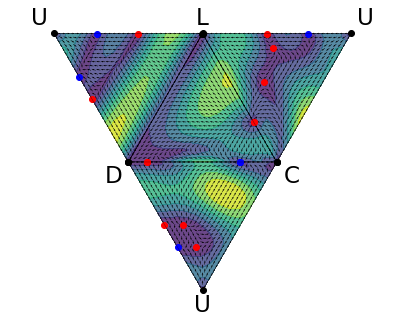

In [15]:
# create the plot axis object
ax = plt.figure().add_subplot(1,1,1)

# define the corners of the triangles in the net plot
tris = tp.net_plot_initialise(ax, thresholdUDCL.strat_names)

# get a list of barycentric grid points for each face of the tetrahedron
lV = tp.net_get_face_mesh(2**5)        # fine mesh
lV_coarse = tp.net_get_face_mesh(2**3) # coarse mesh


# get dynamics

print('This will take about 2 minutes ...')

# find fixed points using coarse grid as start points
fp_baryV = tp.net_find_fixed_points(lV_coarse, thresholdUDCL.deltap_fnc)

 # find gradient of selection at each point on fine grid
strengthsV, dirn_normV = tp.net_calc_grad_on_mesh(tris, lV, thresholdUDCL.deltap_fnc)


# plot dynamics

# rate of change (colour contour)
tp.net_plot_dynamics_rate(ax, tris, lV, strengthsV)

# direction of selection (arrows)
tp.net_plot_dynamics_dirn(ax, tris, lV, dirn_normV)     

# fixed points with colours indicating their stability
tp.net_plot_fixed_points_w_stability(ax, tris, fp_baryV, thresholdUDCL.calc_stability)

plt.show()


The axes correspond to the strategy names in `thresholdUDCL.game_pars['strat_names']`. Evolutionarily stable steady states are marked in blue and unstable states in red. 

Note that stability is calculated with respect to those strategies that are present in the population. For example, the stable state between U and L represents coexistence of Unconditional Cooperators and Liars in the population. However, as we will see below, that population is invasible to D (Unconditional Defectors).

### 4.2 Invasibility of steady states

Invasion fitness can be calculated using the method `calc_invasion_fitness()`. For example, the figure above shows stable coexistence between Liars and Unconditional Cooperators; however, the quiver plot suggests that L+U is invasible to D. We can verify this by checking that the invasion fitness of D at the L+U coexistence is positive.

In the process of generating the plot above, we calculated the positions of the steady states, which are stored in `fp_baryV`. Rows of `fp_baryV` above correspond to faces of the tetrahedron, where the strategy omitted corresponds to the order of strategies in `game_pars['strat_names'` (i.e., omit D, C, L, then U). So we will take the second row (omits C) and format it into a list of lists that replaces the missing $p_C$ with 0.

In [16]:
# replace small numerical values with zeros and 1s

for fp_bary in fp_baryV:
    for fp in fp_bary:
        fp[np.isclose(fp, 0, atol=1e-7)] = 0
        fp[np.isclose(fp, 1, atol=1e-7)] = 1

# take row 0, corresponding to the face with C omitted
fp = [[row[0], 0, row[1], row[2]] for row in fp_baryV[1]]

# print steady states found in a table
print('row |  p_D*  |  p_C*  |  p_L*  |  p_U*')
print('----|--------|--------|--------|--------')

for i, row in enumerate(fp):
    
    print(f' {i}  | {row[0]:6.4f} | {row[1]:6.4f} | {row[2]:6.4f} | {row[3]:6.4f}')


row |  p_D*  |  p_C*  |  p_L*  |  p_U*
----|--------|--------|--------|--------
 0  | 1.0000 | 0.0000 | 0.0000 | 0.0000
 1  | 0.3367 | 0.0000 | 0.0000 | 0.6633
 2  | 0.0000 | 0.0000 | 0.0000 | 1.0000
 3  | 0.5129 | 0.0000 | 0.0000 | 0.4871
 4  | 0.0000 | 0.0000 | 1.0000 | 0.0000
 5  | 0.0000 | 0.0000 | 0.2862 | 0.7138
 6  | 0.0000 | 0.0000 | 0.5670 | 0.4330


The L+U coexistence of interest is in row 5

In [17]:
fp_LU = fp[5]
fp_LU

[0.0, 0, 0.2862222335311656, 0.7137777664680133]

The invasion fitness of D into L+U is positive, which verifies that Unconditional Defectors can invade.

In [18]:
thresholdUDCL.calc_invasion_fitness('D', fp_LU)

0.10000000000153242

After D invades, the plot indicates that the population will be driven towards a stable coexistence between Unconditional Defectors and Unconditional Cooperators, and that the D+U population is not invasible to Coordinating Cooperators.

The D+U coexistence is in row 1 of our table:

In [19]:
fp_DU = fp[1]
fp_DU

[0.33673280514388426, 0, 0.0, 0.6632671948561469]

The invasion fitness of C into D+U is negative, which verifies that Coordinating Cooperators cannot invade.

In [20]:
thresholdUDCL.calc_invasion_fitness('C', fp_DU)

-0.08370323809513192

### 4.2 Explore dynamics in the interior of the strategy space

#### 4.2.1 Steady states, their stability, and their invasibility

One way to find evolutionary steady states is to divide the strategy space into a mesh and use each mesh point as the initial point for the "hybrid" method from `scipy.optimize`. Some functions included in `tetraplot4class` can be used to perform these operations quickly.

In [21]:
ngrid = 3 # the number of grid points on each axis of the strategy space

# divide the tetrahedron into a grid with ngrid points on each axis
lV = tp.tet_get_mesh(ngrid)

# find the fixed points numerically using lV as starting points
fps = tp.tet_find_fixed_points(lV, thresholdUDCL.deltap_fnc)

In [22]:
fps

[array([1., 0., 0., 0.]),
 array([0.87327849, 0.12672151, 0.        , 0.        ]),
 array([5.12919217e-01, 2.93447235e-14, 2.73429392e-14, 4.87080783e-01]),
 array([0.24824622, 0.75175378, 0.        , 0.        ]),
 array([ 3.86197702e-01,  1.26721515e-01, -2.85880061e-16,  4.87080783e-01]),
 array([ 6.79578366e-15, -4.07826290e-23,  1.00000000e+00,  0.00000000e+00]),
 array([ 3.36732805e-01,  7.65325055e-23, -8.20295888e-24,  6.63267195e-01]),
 array([0., 1., 0., 0.]),
 array([-2.23624571e-25,  6.90027467e-01,  3.09972533e-01,  0.00000000e+00]),
 array([ 9.88712395e-11,  4.50522704e-14, -1.42358235e-18,  1.00000000e+00]),
 array([1.11326916e-19, 7.13297953e-23, 5.66987357e-01, 4.33012643e-01]),
 array([-2.30782892e-16, -3.69900125e-16,  2.86222234e-01,  7.13777766e-01])]

The number of steady states that are found depends on the size of the mesh, and this method can be computationally expensive, so we will load precalculated steady states here. The reader is referred to `/scripts/threshold_UDCL/calc_fixedpts_threshold_v1.py` for a full working example of how these steady states were found.

In [24]:
import pandas as pd

# filename where precalculated steady states are stored
fname = '../results/threshold_UDCL/fixedpts_stability_threshold_v1_members_recruit_ngrid_7_q_8000.csv'

# get the precalculated steady states from the file
df = pd.read_csv(fname)
fps = list(df[['p_' + strat_name + '*' for strat_name in game_pars['strat_names']]].to_numpy())
list(enumerate(fps))

# recall the order of the strategy names is: D, C, L, U

[(0, array([1., 0., 0., 0.])),
 (1, array([0.87327849, 0.12672151, 0.        , 0.        ])),
 (2, array([0.51291922, 0.        , 0.        , 0.48708078])),
 (3, array([0.3861977 , 0.12672151, 0.        , 0.48708078])),
 (4, array([0.24824622, 0.75175378, 0.        , 0.        ])),
 (5, array([0.        , 0.37829538, 0.39571445, 0.22599017])),
 (6, array([0.01299912, 0.11380482, 0.45329404, 0.41990201])),
 (7, array([0., 1., 0., 0.])),
 (8, array([0.33673281, 0.        , 0.        , 0.66326719])),
 (9, array([0.        , 0.11502314, 0.4683829 , 0.41659396])),
 (10, array([0., 0., 1., 0.])),
 (11, array([0.        , 0.        , 0.56698736, 0.43301264])),
 (12, array([0.        , 0.69002747, 0.30997253, 0.        ])),
 (13, array([0.21001129, 0.12672151, 0.        , 0.66326719])),
 (14, array([0.        , 0.        , 0.28622223, 0.71377777])),
 (15, array([0., 0., 0., 1.]))]

The stability of each fixed point can be checked with the `calc_stability()` method. 

For example, the figure above indicates there are two steady states in the L+U population, and the steady state with more U is stable while the steady state with more L is unstable. We can verify that as follows:

In [27]:
fp_LU1 = list(fps[11])
fp_LU2 = list(fps[14])

stab_LU1 = thresholdUDCL.calc_stability(fp_LU1)
stab_LU2 = thresholdUDCL.calc_stability(fp_LU2)

print(f'Steady state {fp_LU1} is {stab_LU1}')
print(f'Steady state {fp_LU2} is {stab_LU2}')

Steady state [0.0, 0.0, 0.5669873566263232, 0.4330126433739248] is unstable
Steady state [0.0, 0.0, 0.2862222334823706, 0.7137777664548502] is stable


The figure also indicates that the stable coexistence of L+U is invasible to Coordinating Cooperators C, which we can check with the `calc_invasion_fitness` method by verifying that C has a positive invasion fitness:

In [28]:
inv_fit_C = thresholdUDCL.calc_invasion_fitness('C', fp_LU2)
inv_fit_C

0.040407581491670674

In contrast, the figure indicates that the stable C+D coexistence is uninvasible to both U and L. We can check this by verifying that both invasion fitnesses are negative:

In [31]:
fp_CD = list(fps[1])

inv_fit_U = thresholdUDCL.calc_invasion_fitness('U', fp_CD)
inv_fit_L = thresholdUDCL.calc_invasion_fitness('L', fp_CD)

print(f'The invasion fitness of U into C+D is {inv_fit_U}')
print(f'The invasion fitness of L into C+D is {inv_fit_L}')

The invasion fitness of U into C+D is -0.9759771428541852
The invasion fitness of L into C+D is -0.11028370559697076


#### 4.2.1 Plotting trajectories when $m=4$

The `tetraplot4class` module includes a number of functions for plotting the evolutionary dynamics of a 4-strategy system in 3 dimensions. 

For example, let's say we wish to plot a number of trajectories starting near the all-U population.

In [32]:
pert = 0.01
nopts = 5
vals = pert*np.linspace(0, 1, nopts)[1:]

nopts -= 1

v0V = list() # store starting points for the trajectories
for ptD in range(nopts):

    for ptC in range(nopts-ptD):

        ptL = nopts-ptD-ptC-1
        pts = [ptD, ptC, ptL]
        v0 = [vals[i] for i in pts] + [1-pert]
        v0V.append(v0)
v0V

[[0.0025, 0.0025, 0.01, 0.99],
 [0.0025, 0.005, 0.0075, 0.99],
 [0.0025, 0.0075, 0.005, 0.99],
 [0.0025, 0.01, 0.0025, 0.99],
 [0.005, 0.0025, 0.0075, 0.99],
 [0.005, 0.005, 0.005, 0.99],
 [0.005, 0.0075, 0.0025, 0.99],
 [0.0075, 0.0025, 0.005, 0.99],
 [0.0075, 0.005, 0.0025, 0.99],
 [0.01, 0.0025, 0.0025, 0.99]]

We can calculate each trajectory by numerically integrating forward in time (solves initial value problem with `solve_ivp()` from `scipy.integrate`):

In [36]:
xM = list()
yM = list()
zM = list()

for v0 in v0V:

    print(f'doing v0 = {v0}')
    
    # forward 40 timesteps
    xV, yV, zV = tp.get_trajectory(vertexs, v0, [0, 40], thresholdUDCL.deltap_fnc)
    xM.append(xV)
    yM.append(yV)
    zM.append(zV)

doing v0 = [0.0025, 0.0025, 0.01, 0.99]
doing v0 = [0.0025, 0.005, 0.0075, 0.99]
doing v0 = [0.0025, 0.0075, 0.005, 0.99]
doing v0 = [0.0025, 0.01, 0.0025, 0.99]
doing v0 = [0.005, 0.0025, 0.0075, 0.99]
doing v0 = [0.005, 0.005, 0.005, 0.99]
doing v0 = [0.005, 0.0075, 0.0025, 0.99]
doing v0 = [0.0075, 0.0025, 0.005, 0.99]
doing v0 = [0.0075, 0.005, 0.0025, 0.99]
doing v0 = [0.01, 0.0025, 0.0025, 0.99]


The plot can then be generated showing the trajectories

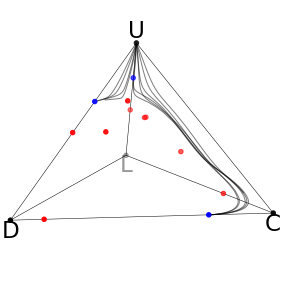

In [38]:
# initialise the plot

ax = plt.figure().add_subplot(projection='3d')
vertexs = tp.tet_plot_initialise(ax, thresholdUDCL.strat_names)

# include the steady states and information about their stability

# corresponding list of stability information from the file
stabV = list(df['stability'])

# encode each stability as a colour
colourV = ['red' if stab == 'unstable' else 'blue' if stab == 'stable' else 'black' for stab in stabV]

# convert bary coordinates to xyz coords
xyzV = [ list(tp.tet_bary2xyz(vertexs, ls)) for ls in fps ]
xV, yV, zV = zip(*xyzV)

# plot fixed point in colour corresponding to stability
ax.scatter(xV, yV, zV, color=colourV)

# add each trajectory to the plot

for xV, yV, zV in zip(xM, yM, zM):
    ax.plot(xV, yV, zV, color='black', lw=1, alpha=0.5)

# show the plot

plt.show()

This example is also provided as a stand-alone script in `/scripts/threshold_UDCL/plot_tet3d_threshold_v1_startU.py`.